<a href="https://colab.research.google.com/github/Vigneshthanga/SpecialTopics/blob/master/Assignment_1_Part_1/FeatureExtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing torch and torchvision library

In [30]:
import torch
from torchvision.models.resnet import ResNet, BasicBlock
from torchvision.datasets import MNIST

## Download MNIST Data

In [31]:
mnist_train = MNIST(root='.', download=True, train=True)

In [32]:
mnist_train_data = mnist_train.train_data.float()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [33]:
from torchvision.transforms.transforms import *

## Composing Transofrmation List

In [34]:
transformList = Compose([ Resize((224, 224)),ToTensor(), Normalize((mnist_train_data.mean()/255), (mnist_train_data.std()/255))])

In [35]:
from torch.utils.data import DataLoader

In [36]:
mnist_train_data.size()

torch.Size([60000, 28, 28])

## Train and Validation dataloader

In [37]:
train_loader = DataLoader(MNIST(download=True, root=".", transform=transformList, train=True),
                              batch_size=256, shuffle=True)

In [38]:
val_loader = DataLoader(MNIST(download=False, root=".", transform=transformList, train=False),
                              batch_size=256, shuffle=False)

In [39]:
val_loader.dataset.test_data.size()

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


torch.Size([10000, 28, 28])

## Custom Resnet

In [40]:
class CustomResNet(ResNet):
    def __init__(self):
        super(CustomResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
    def forward(self, x):
        return torch.softmax(super(CustomResNet, self).forward(x), dim=-1)

## Make use of GPU if available

In [41]:
flag = False
if torch.cuda.is_available():
  flag = True
  print('cuda available')

cuda available


In [42]:
if (flag):
  device = "cuda:0"
else:
  device = "cpu"

In [43]:
device

'cuda:0'

In [44]:
model = CustomResNet().to(device)

In [45]:
print(model)

CustomResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [46]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adadelta(model.parameters())

In [47]:
train_batch_len = len(train_loader)
val_batch_len = len(val_loader)

## Image Visualization after transformations

tensor([[-0.4240, -0.4240, -0.4240,  ..., -0.4240, -0.4240, -0.4240],
        [-0.4240, -0.4240, -0.4240,  ..., -0.4240, -0.4240, -0.4240],
        [-0.4240, -0.4240, -0.4240,  ..., -0.4240, -0.4240, -0.4240],
        ...,
        [-0.4240, -0.4240, -0.4240,  ..., -0.4240, -0.4240, -0.4240],
        [-0.4240, -0.4240, -0.4240,  ..., -0.4240, -0.4240, -0.4240],
        [-0.4240, -0.4240, -0.4240,  ..., -0.4240, -0.4240, -0.4240]])


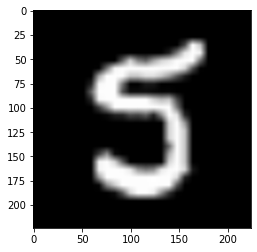

In [48]:
import matplotlib.pyplot as plt
import numpy as np
for data in enumerate(train_loader):
  image = data[1][0]
  img = image[1].reshape(224,224)
  print(img)
  plt.imshow(img.numpy().astype(np.float32), cmap=plt.get_cmap("gray"))
  break

## Utility functions to calculate metric and display scores

In [49]:
import inspect
def calculate_metric(metric_fn, true_y, pred_y):
    if "average" in inspect.getfullargspec(metric_fn).args:
        return metric_fn(true_y, pred_y, average="macro")
    else:
        return metric_fn(true_y, pred_y)
    
def print_scores(p, r, f1, a, batch_size):
    for name, scores in zip(("precision", "recall", "F1", "accuracy"), (p, r, f1, a)):
        print(f"\t{name.rjust(14, ' ')}: {sum(scores)/batch_size:.4f}")

## Train the classifier model.

In [50]:
from tqdm.autonotebook import tqdm
from sklearn.metrics import *
import time
losses = []
start_ts = time.time()
for epoch in range(5):
  total_loss = 0
  progress = tqdm(enumerate(train_loader), desc="Loss: ", total=train_batch_len)
  model.train()

  for i, data in progress:
    X = data[0].to(device)
    y = data[1].to(device)
    model.zero_grad()

    outputs = model(X)
    loss = loss_fn(outputs, y)
    loss.backward()
    optimizer.step()

    current_loss = loss.item()
    total_loss += current_loss

    progress.set_description("Loss: {:.4f}".format(total_loss/(i+1)))

  if (device == "cuda:0"):
    torch.cuda.empty_cache()

  val_losses = 0
  precision, recall, f1, accuracy = [], [], [], []
    
  # set model to evaluating (testing)
  model.eval()
  with torch.no_grad():
      for i, data in enumerate(val_loader):
          X, y = data[0].to(device), data[1].to(device)

          outputs = model(X)                                    # this gets the prediction from the network

          val_losses += loss_fn(outputs, y)

          predicted_classes = torch.max(outputs, 1)[1]          # get class from network's prediction
            
          # calculate P/R/F1/A metrics for batch
          for acc, metric in zip((precision, recall, f1, accuracy), 
                              (precision_score, recall_score, f1_score, accuracy_score)):
              acc.append(
                  calculate_metric(metric, y.cpu(), predicted_classes.cpu())
              )
          
  print(f"Epoch {epoch+1}/{5}, training loss: {total_loss/train_batch_len}, validation loss: {val_losses/val_batch_len}")
  print_scores(precision, recall, f1, accuracy, val_batch_len)
  losses.append(total_loss/train_batch_len) # for plotting learning curve
print(f"Training time: {time.time()-start_ts}s")

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/5, training loss: 1.6519087943624944, validation loss: 1.683925986289978
	     precision: 0.7598
	        recall: 0.7906
	            F1: 0.7541
	      accuracy: 0.7924



Epoch 2/5, training loss: 1.4792203091560525, validation loss: 1.545719027519226
	     precision: 0.9385
	        recall: 0.9222
	            F1: 0.9187
	      accuracy: 0.9210



Epoch 3/5, training loss: 1.4719538059640438, validation loss: 1.479669451713562
	     precision: 0.9851
	        recall: 0.9840
	            F1: 0.9839
	      accuracy: 0.9842



Epoch 4/5, training loss: 1.4690857801031558, validation loss: 1.472325086593628
	     precision: 0.9897
	        recall: 0.9896
	            F1: 0.9894
	      accuracy: 0.9896



Epoch 5/5, training loss: 1.4673371989676294, validation loss: 1.4745811223983765
	     precision: 0.9884
	        recall: 0.9879
	            F1: 0.9878
	      accuracy: 0.9883
Training time: 1093.3026704788208s
